#Практическая работа №5

###__1.__ Сформировать с помощью sklearn.make_classification датасет из 1000 объектов с двумя признаками, обучить случайный лес из 1, 3, 10 и 50, 100, 200 деревьев и визуализировать их разделяющие гиперплоскости на графиках (по подобию визуализации деревьев из предыдущего урока, необходимо только заменить вызов функции predict на tree_vote). Сделать выводы о получаемой сложности гиперплоскости и недообучении или переобучении случайного леса в зависимости от количества деревьев в нем.

In [103]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

In [104]:
# Реализуем класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels
        self.prediction = self.predict()
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
          if label not in classes:
              classes[label] = 0
          classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction 
    
    def classify_object(self, obj):
        return self

In [105]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле
    
    def classify_object(self, obj):
        if obj[self.index] <= self.t:
          return self.true_branch.classify_object(obj)
        else:
          return self.false_branch.classify_object(obj)
        

In [106]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [107]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [108]:
def get_subsample(len_sample, len_subsample):
    # будем сохранять не сами признаки, а их индексы
    sample_indexes = [i for i in range(len_sample)]
    
    subsample = []
    random.shuffle(sample_indexes)
    for _ in range(min(len_sample, len_subsample)):
        subsample.append(sample_indexes.pop())
        
    return subsample

In [109]:
# Реализуем класс дерева

class Tree:

    def __init__(self, min_leaf=5, criteria_call=gini, max_level=1000, max_features=1000000):
        self.root = None
        self.min_leaf = min_leaf # минимальное количество объектов в узле
        self.criteria_call = criteria_call #функция расчета критерия информативности
        self.max_level = max_level #максимальная глубина дерева
        self.max_features = max_features #максимальное количество обрабатываемых признаков 

    def set_min_leaf(self, min_leaf):
        self.min_leaf = min_leaf
        return self 
    
    def set_criteria_call(self, criteria_call):
        self.criteria_call = criteria_call
        return self

    def set_max_level(self, max_level):
        self.max_level = max_level
        return self
    
    def set_max_features(self, max_features):
        self.max_features = max_features
        return self

    def classify_object(self, obj):
        return self.root.classify_object(obj)

    def predict(self, data):
        classes = []
        for obj in data:
            leaf_ = self.classify_object(obj)
            classes.append(leaf_.prediction)
        return classes

    def in_leaf(self, data):
        classes = []
        for obj in data:
            leaf_ = self.classify_object(obj)
            classes.append(obj in leaf_.data)
        return classes

    def build(self, data, labels):
        self.root = self.build_tree(data, labels)
        return self
    
    def build_tree(self, data, labels, level=0):

        quality, t, index = self.find_best_split(data, labels)

        #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
        if (quality == 0) | (level >= self.max_level):
            return Leaf(data, labels)

        true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

        # Рекурсивно строим два поддерева
        true_branch = self.build_tree(true_data, true_labels, level=level+1)
        false_branch = self.build_tree(false_data, false_labels, level=level+1)

        # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
        return Node(index, t, true_branch, false_branch)
    
    def find_best_split(self, data, labels):
        current_criteria = self.criteria_call(labels)

        best_quality = 0
        best_t = None
        best_index = None
    
        n_features = data.shape[1]

        # выбор индекса из подвыборки длиной sqrt(n_features)
        subsample = get_subsample(n_features, self.max_features)

        for index in subsample:
            # будем проверять только уникальные значения признака, исключая повторения
            t_values = np.unique([row[index] for row in data])
        
            for t in t_values:
                true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
                #  пропускаем разбиения, в которых в узле остается менее 5 объектов
                if len(true_data) < self.min_leaf or len(false_data) < self.min_leaf:
                    continue
            
                current_quality = self.quality(true_labels, false_labels, current_criteria)
            
                #  выбираем порог, на котором получается максимальный прирост качества
                if current_quality > best_quality:
                  best_quality, best_t, best_index = current_quality, t, index

        return best_quality, best_t, best_index

    def quality(self, left_labels, right_labels, current_criteria):
        # доля выбоки, ушедшая в левое поддерево
        p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    
        return current_criteria - p * self.criteria_call(left_labels) - (1 - p) * self.criteria_call(right_labels)

In [110]:
def get_bootstrap(data, labels, N):
    n_samples = data.shape[0]
    bootstrap = []
    
    for i in range(N):
        b_data = np.zeros(data.shape)
        b_labels = np.zeros(labels.shape)
        for j in range(n_samples):
            sample_index = random.randint(0, n_samples-1)
            b_data[j] = data[sample_index]
            b_labels[j] = labels[sample_index]            
        bootstrap.append((b_data, b_labels))
        
    return bootstrap

In [120]:
# Реализуем класс лес

class Forest:

    def __init__(self, n_trees, min_leaf=5, criteria_call=gini, max_level=1000, max_features=1000000):  
        self.n_trees = n_trees
        self.forest = []
        self.min_leaf = min_leaf # минимальное количество объектов в узле
        self.criteria_call = criteria_call #функция расчета критерия информативности
        self.max_level = max_level #максимальная глубина дерева
        self.max_features = max_features #максимальное количество обрабатываемых признаков 

    def set_min_leaf(self, min_leaf):
        self.min_leaf = min_leaf
        return self 
    
    def set_criteria_call(self, criteria_call):
        self.criteria_call = criteria_call
        return self

    def set_max_level(self, max_level):
        self.max_level = max_level
        return self
    
    def set_max_features(self, max_features):
        self.max_features = max_features
        return self
    
    def build(self, data, labels):
        bootstrap = get_bootstrap(data, labels, self.n_trees)

        for b_data, b_labels in bootstrap:
            self.forest.append(Tree(min_leaf=self.min_leaf, 
                                    criteria_call=self.criteria_call, 
                                    max_level=self.max_level, 
                                    max_features=self.max_features).build(b_data, b_labels))

    def predict(self, data):

        # добавим предсказания всех деревьев в список
        predictions = []
        for tree in self.forest:
            predictions.append(tree.predict(data))
    
        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))
    
        # выберем в качестве итогового предсказания для каждого объекта то,
        # за которое проголосовало большинство деревьев
        voted_predictions = []
        for obj in predictions_per_object:
            voted_predictions.append(max(set(obj), key=obj.count))
        
        return voted_predictions
    
    def oob(self, data, labels):

        # добавим используемость всех деревьев в список
        predictions = []
        in_trees = []
        for tree in self.forest:
            predictions.append(tree.predict(data))
            in_trees.append(tree.in_leaf(data))

        # сформируем список с предсказаниями для каждого объекта
        predictions_per_object = list(zip(*predictions))
        # сформируем список с используемостью для каждого объекта
        in_trees_per_object = list(zip(*in_trees))

        # Для каждого объекта посчитаем ошибку на тех деревьях
        # в обучении которых объект не принимал участие (его нет в листьях)
        err = 0
        for i, obj in enumerate(predictions_per_object):
            err_obj = 0
            n_obj = 0
            for j, predict in enumerate(obj):
                if in_trees_per_object[i][j] == False:
                    err_obj += np.abs(labels[i] - predict)
                    n_obj += 1
            if n_obj > 0:
                err += err_obj / n_obj
        
        return err


In [112]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [113]:
# Визуализируем дерево на графике

def plot_flat(model, 
              train_data, train_labels, train_accuracy, 
              test_data, test_labels, test_accuracy):
    def get_meshgrid(data, step=.05, border=1.2):
        x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
        y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
        return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

    plt.figure(figsize = (16, 7))

    # график обучающей выборки
    plt.subplot(1,2,1)
    xx, yy = get_meshgrid(train_data)
    mesh_predictions = np.array(model.predict(np.c_[xx.ravel(), yy.ravel()] )).reshape(xx.shape)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
    plt.title(f'Train accuracy={train_accuracy:.2f}')

    # график тестовой выборки
    plt.subplot(1,2,2)
    plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
    plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
    plt.title(f'Test accuracy={test_accuracy:.2f}')

In [114]:
# сгенерируем данные
classification_data, classification_labels = datasets.make_classification(n_samples=1000, n_features = 2, n_informative = 2, 
                                                      n_classes = 2, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

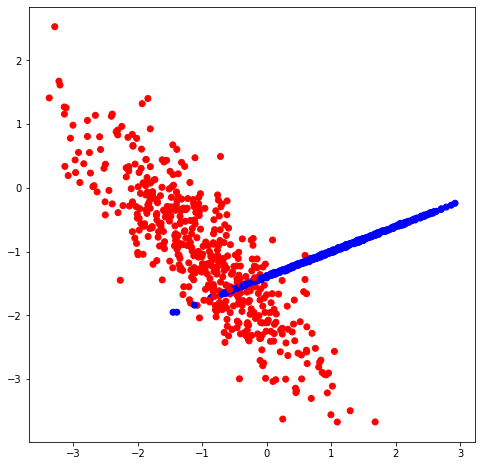

In [115]:
# визуализируем сгенерированные данные

colors = ListedColormap(['red', 'blue'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)

In [116]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [118]:
def test_forest(n_trees):
    random.seed(42)

    test_forest = Forest(n_trees).set_min_leaf(1).set_max_features(int(np.sqrt(train_data.shape[1])))
    test_forest.build(train_data, train_labels)
    # Получим ответы для обучающей выборки 
    train_answers = test_forest.predict(train_data)
    # И получим ответы для тестовой выборки
    answers = test_forest.predict(test_data)
    # Точность на обучающей выборке
    train_accuracy = accuracy_metric(train_labels, train_answers)
    # Точность на тестовой выборке
    test_accuracy = accuracy_metric(test_labels, answers)

    plot_flat(test_forest, train_data, train_labels, train_accuracy, test_data, test_labels, test_accuracy)
    print(f'Out-of-Bag на обучающей выборке {test_forest.oob(train_data, train_labels)}')

Для леса из 1 дерева

Out-of-Bag на обучающей выборке 13.0


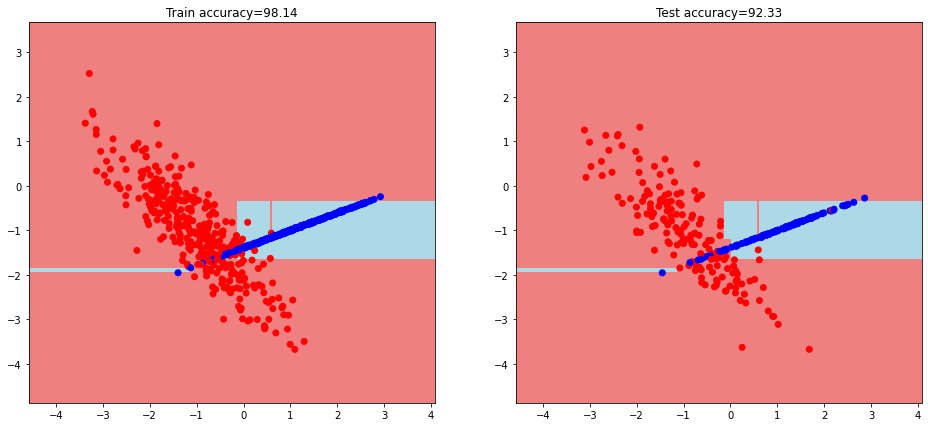

In [121]:
test_forest(1)

Для леса из 3 деревьев

Out-of-Bag на обучающей выборке 30.833333333333332


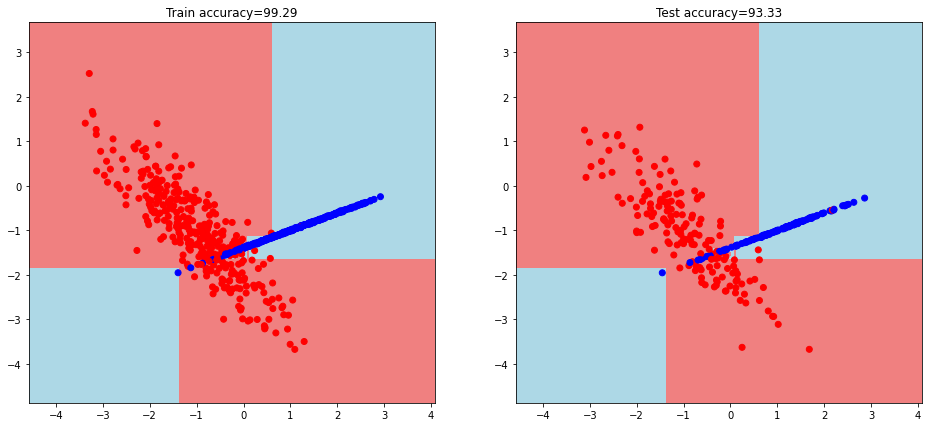

In [122]:
test_forest(3)

Для леса из 10 деревьев

Out-of-Bag на обучающей выборке 42.44444444444444


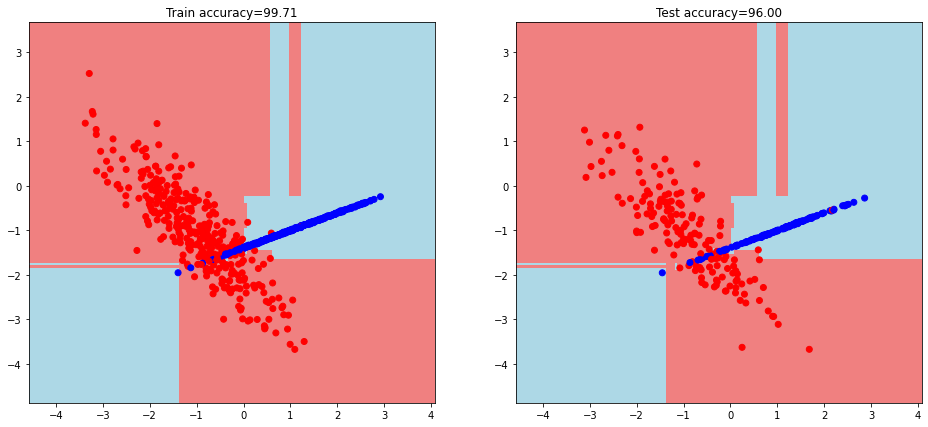

In [123]:
test_forest(10)

Для леса из 50 деревьев

Out-of-Bag на обучающей выборке 37.809513401987175


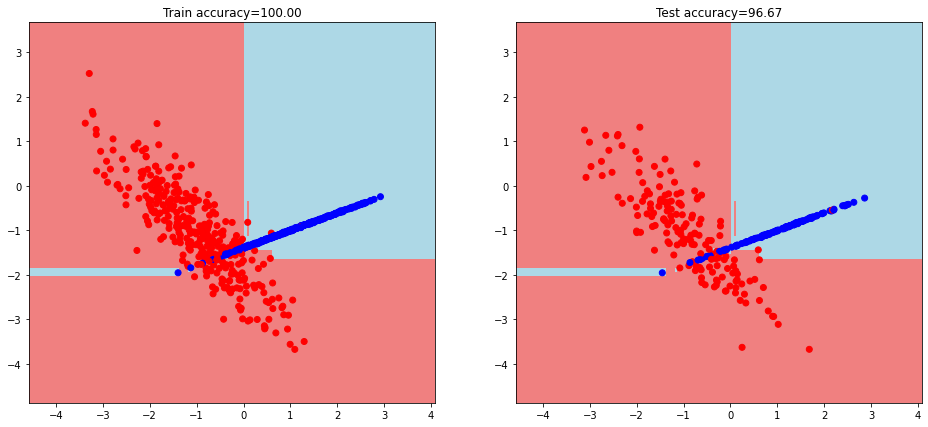

In [124]:
test_forest(50)

Для леса из 100 деревьев

Out-of-Bag на обучающей выборке 37.67309513962657


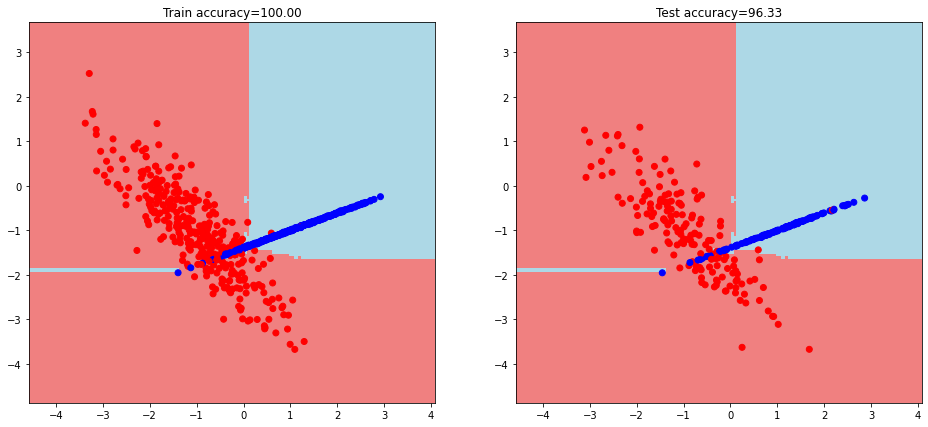

In [125]:
test_forest(100)

Для леса из 200 деревьев

Out-of-Bag на обучающей выборке 37.555112360877025


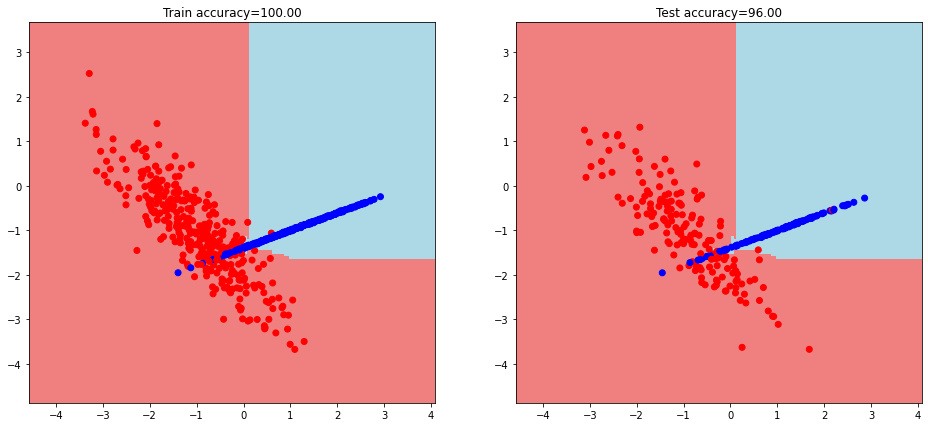

In [126]:
test_forest(200)

После 50 деревьев качество предсказание ухудшается, модель переучена.

## __2 (опция).__ Заменить в реализованном алгоритме проверку с помощью отложенной выборки на Out-of-Bag.

Оценка качаства Out-of-Bag чуствительна к количеству деревьев при их малом количестве, так как с ростом кол-ва деревьев увеличивается количество объектов, принимающих участие в рассчете оценки качества (при однои дереве 37% объектов не принимают участие в расчете OOB). Может быть нужно было бы еще усреднить по количеству объектов используемых для расчета OOB

In [127]:
    test_forest = Forest(50).set_min_leaf(1).set_max_features(int(np.sqrt(train_data.shape[1])))
    test_forest.build(classification_data, classification_labels)
    test_forest.oob(classification_data, classification_labels)

52.50918224906623

In [129]:
    test_forest = Forest(1).set_min_leaf(1).set_max_features(int(np.sqrt(train_data.shape[1])))
    test_forest.build(classification_data, classification_labels)
    test_forest.oob(classification_data, classification_labels)

21.0